# Discrete Environments

## Libraries used in Notebook

In [1]:
import gymnasium as gym
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Introduction to Gymnasium
[Gymnasium](https://gymnasium.farama.org/) is a Python library designed to provide standardized environments for developing and testing reinforcement learning algorithms. It offers a simple and consistent API that allows agents to interact with a wide variety of environments, from basic grid-based simulations to complex physics-driven tasks.

Each environment in Gymnasium follows a standard interface:

- `env.reset()` initialized the environment and returns the initial observation.
- `env.step(action)` takes an action and returns a tuple: **observation**, **reward**, **terminated**, **truncated**, and **info**.

Here's a minimal example of using a Gymnasium environment:

In [2]:
env = gym.make("Taxi-v3")
observation, info = env.reset()

for _ in range(100):
    action = env.action_space.sample()  # take random action
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

### Code overview
We begin by creating the environment with `gym.make("Taxi-v3")`. In this game the agent must pick up passengers and drop them off at one of four locations.

We then call `env.reset()` to initialize the environment and get the initial state.

The interaction between agent and environment happens in a loop. At each timestep, the agent chooses as action - here randomly using `env.action_space.sample()` - and passes it to `env.step(action)`. This function returns:
- the next state,
- a reward,
- and two flags: `terminated` (episode ended by success or failure) and `truncated` (time or step limit reached).

If either flag is `True`, the episode ands anf the environment is reset with `env.reset()`.

Gymnasium is part of the [Farama Foundation](https://farama.org/) ecosystem and is actively maintained as a successor to the original OpenAI Gym.

## Q-learning Algorithm

Q-learning is one of the most popular reinforcement learning algorithms. Its main goal is to learn a **Q-value function**, $Q(s, a)$, which estimates the expected reward an agent can obtain by taking an action $a$ in a state $s$, and then following the optimal policy from there on.

In this project, we use the classic table-based version of Q-learning, where the Q-values are stored in a **lookup table**. This approach works well when the state and action spaces are **discrete and finite**, as is the case in environments like FrozenLake.

### Q-learning update rule

At each step of the learning process, the Q-value is updated using the **Bellman equation**, modified for Q-learning:

$$
Q(s, a) \leftarrow (1 - \alpha) \cdot Q(s, a) + \alpha \cdot \left[ r + \gamma \cdot \max_{a'} Q(s', a') \right]
$$

#### Where:
- $s$ - current state
- $a$ - action taken by the agent
- $r$ - reward received after taking action $a$ in state $s$
- $s'$ - next state
- $\alpha$ - learning rate (how quickly we update our knowledge)
- $\gamma$ - discount factor (how much we value future rewards)
- $\max_{a'} Q(s', a')$ - estimated best future reward from state $s'$

The discount factor $\gamma$ (between 0 and 1) determines the importance of future rewards:
- $\gamma \approx 0$: short-term focus
- $\gamma \approx 1$: long-term planning


### Implementing the Q-learning Algorithm

In [3]:
env = gym.make("Taxi-v3", render_mode="rgb_array")

discount_factor = 0.9
learning_rate = 0.9
episodes = 10000
epsilon = 0.1
q_table = np.zeros((env.observation_space.n, env.action_space.n))
episode_rewards = []

for episode in range(episodes):
    state, _ = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    while not terminated and not truncated:
        action = np.argmax(q_table[state,:])

        new_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

        # bellman equation
        q_table[state, action] = (
                (1 - learning_rate) * q_table[state, action] +
                learning_rate * (reward + discount_factor * np.max(q_table[new_state, :])))

        state = new_state
    episode_rewards.append(total_reward)
env.close()

### Code overview

1. The environment is reset at the start of each episode.
2. At every step, the agent selects an action using a **greedy policy**:
   `action = np.argmax(q_table[state, :])`
3. The environment responds with the next state, a reward, and a signal indicating whether the episode has ended.
4. The Q-value is updated using the Q-learning rule:

   $$
   Q(s, a) \leftarrow (1 - \alpha) \cdot Q(s, a) + \alpha \cdot \left[ r + \gamma \cdot \max_{a'} Q(s', a') \right]
   $$

5. The total reward for each episode is stored for later analysis.
6. After training, the environment is closed with `env.close()`.

### Greedy policy vs $\epsilon$-greedy policy

In RL two learning stages can be differentiated - **exploration** and **exploitation**. Exploitation is choosing the current best-known move based on previous knowledge when exploration is trying to reach new, unknown states that might not be optimal in order to find a new, possibly better strategy.

In the example above we used `action = np.argmax(q_table[state,:])` - pure exploitation - which might lead to getting stuck in suboptimal paths and never discovering more rewarding states.

An alternative for this is **$\epsilon$-greedy exploration** where a small randomness is introduced:

```python
epsilon = 0.1  # explore 10% of the time

if np.random.uniform(0, 1) < epsilon:
    action = env.action_space.sample()  # random action (explore)
else:
    action = np.argmax(q_table[state, :])  # best action (exploit)
```

## Running the Trained Model

In [4]:
state, _ = env.reset()
terminated = False
truncated = False
rewards = 0
while not terminated and not truncated:
    action = np.argmax(q_table[state,:])
    state, reward, terminated, truncated, info = env.step(action)
    rewards += reward

    cv2.imshow('Taxi', cv2.cvtColor(env.render(), cv2.COLOR_RGB2BGR))
    cv2.waitKey(250)
cv2.destroyAllWindows()

After training, we can demonstrate the agent's performance by running the environment like at the beginning but instead of choosing a random action, the agents now selects the best-known action for the current state using `np.argmax(q_table[state, :])`. This means it chooses the action with the highest Q-value - the one that is expected to lead to the highest long-term reward.

Gymnasium allows visualization using `cv2` by setting the `render_mode` to `"rgb_array"` when the environment was created.


## Evaluating the Model

After learning the model can then be later evaluated with plotting a learning curved based on total reward reached in each episode.

Text(0.5, 1.0, 'Taxi learning curve')

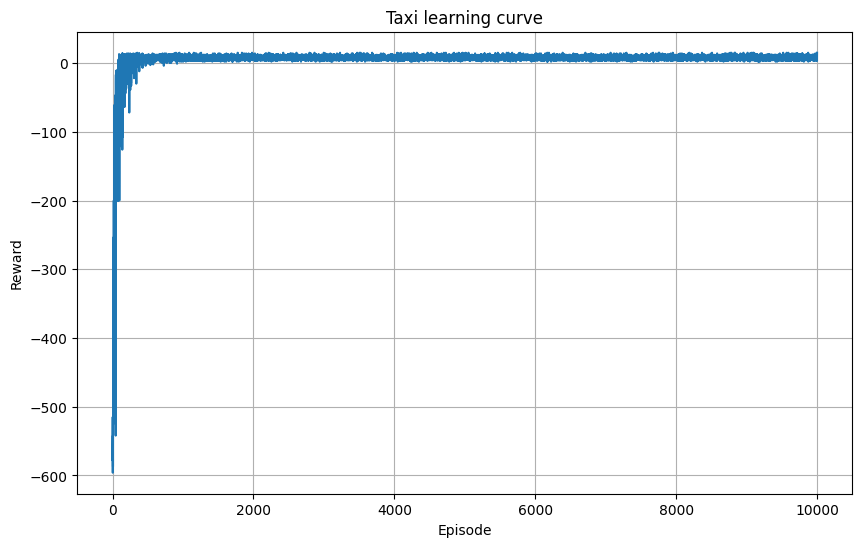

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid()
plt.title('Taxi learning curve')

## Sources
- https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html
- https://gymnasium.farama.org/index.html